<a href="https://colab.research.google.com/github/wsilveira-splunk/channel_capacity/blob/master/channel_capacity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [18]:
snr_db = list(range(-8, 31, 1))
#snr_db = np.arange(-8, 30.1, 0.5).tolist()
snr = list(map(lambda x: pow(10, (x/10)), snr_db))
C_gaussian_ch = list(map(lambda x: 0.5*math.log2(1+x), snr))

p = list(map(lambda x: 0.5*math.erfc(math.sqrt(x/2)), snr))
C_bsc = list(map(lambda x: 1 - (x*math.log2(1/x)+(1-x)*math.log2(1/(1-x))), p))
#C_bsc = 

In [16]:
print(len(snr_db))
print(len(snr))
print(len(C_gaussian_ch))
print(len(p))
print(len(C_bsc))

77
77
77
77
77


In [9]:
print(C_bsc)

[0.07022215929591624, 0.08759455653684622, 0.10900898566672124, 0.13526214105962575, 0.1672267680126518, 0.2058097570411085, 0.25187607582833205, 0.30612628238224704, 0.3689172325944581, 0.4400241733434267, 0.5183624895400445, 0.6017232721037529, 0.6866274705175137, 0.7684526925871606, 0.8419928429244369, 0.9025071978630671, 0.947052584827646, 0.9755393526513939, 0.9907943536971002, 0.9973279822516934, 0.9994417593792412, 0.9999230545523898, 0.9999937295150298, 0.9999997368295345, 0.9999999952184656, 0.9999999999697734, 0.9999999999999494, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


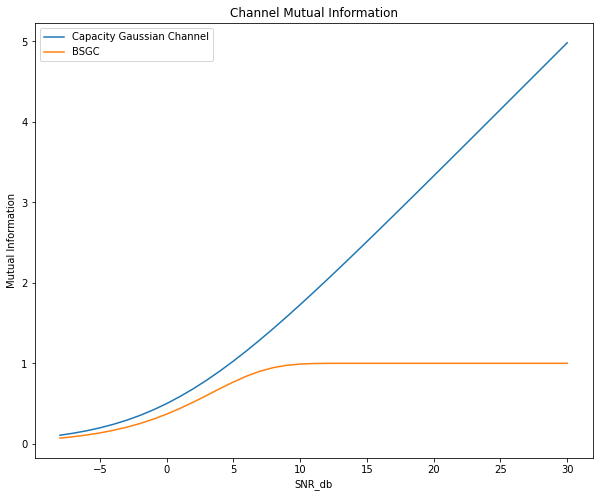

In [23]:
plt.figure(figsize=(10,8)) 
plt.plot(snr_db, C_gaussian_ch, label='Capacity Gaussian Channel') 
plt.plot(snr_db, C_bsc, label='BSGC')
plt.title('Channel Mutual Information')
plt.xlabel('SNR_db')
plt.ylabel('Mutual Information')
plt.legend()
plt.show()